# Data Science and Modelling

## Bayesian Analysis

### Prelude - A Simple Example

An example Bayesian analysis:

Let's take the following dataset:

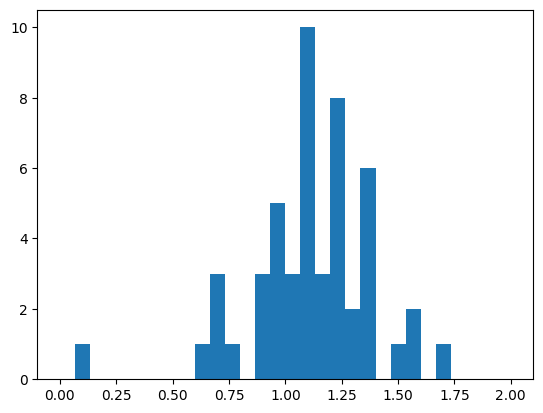

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

mu_true = 1.1
sigma_true = 0.25
sample = np.random.normal(loc=mu_true, scale=sigma_true, size=(50))
# Pretend we dont see the previous lines; we've just been given some random data in a file

# Let's plot it
fig, ax = plt.subplots()
entries, edges, _ = ax.hist(sample, bins=30, range=(0, 2))

This looks kinda normally distributed (wink), the mean might be around 1 somewhere, with std dev around 0.3 or so (99.5% of data within 3 sigma). Let's guess that as a prior for the parameters, using a normal distribution to model our uncertainty in our guessed parameters: 

In [2]:
def prior(mu, sigma):
    return norm.pdf(mu, 1, 0.2) * norm.pdf(sigma, 0.3, 0.1)

Our likelihood function is then the model we are testing (a normal distribution) with the parameters we're testing, applied to each data point and multiplied across all points: $$\mathcal{L}(\mathbf{D}| \mathbf{\theta}) = \prod_i p(x_i| \mathbf{\theta}),$$ for $p$ our proposed PDF, $x_i$ the data points in our dataset $\mathbf{D}$, and $\mathbf{\theta}$ the parameters of the PDF we are testing.

In [3]:
def likelihood(x, mu, sigma):
    return np.prod(norm.pdf(x, loc=mu, scale=sigma))

Plotting the prior over the span of possible datapoints:

Text(0, 0.5, 'std dev')

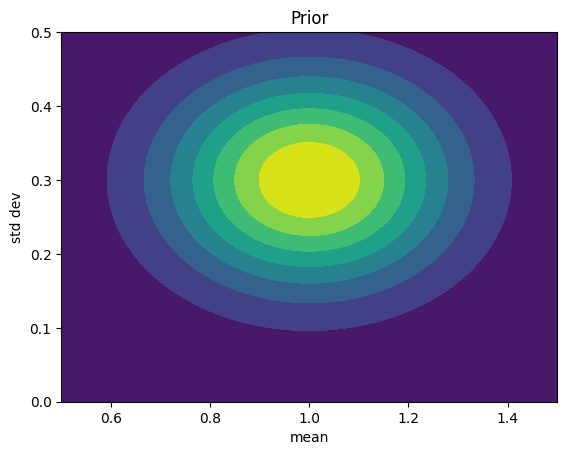

In [4]:
mu = np.linspace(0.5, 1.5, 101, endpoint=True)
sigma = np.linspace(0, 0.5, 101, endpoint=True)

Mu, Sigma = np.meshgrid(mu, sigma)
prior_pdf = prior(Mu, Sigma)

fig, ax = plt.subplots()
ax.tricontourf(
    Mu.flatten(), Sigma.flatten(), prior_pdf.flatten(), extent=[0.5, 1.5, 0.5, 0]
)
# ax.scatter(mu_true, sigma_true, marker="o", color="red")
ax.set_title("Prior")
ax.set_xlabel("mean")
ax.set_ylabel("std dev")
# fig.colorbar(plot, ax=ax)

The red point indicates the "true" mean and std dev that we used to produce the data. 

A frequentist might say that the red point exists through some unwritten rules of nature, and that our estimators are attempting to characterise the likely locations of this point, hoping that as we include more data our determination of the red points location gets better. 

A Bayesianist might say that the red point doesn't actually exist, and that our posterior captures the span of possible population values of $\mu$ and $\sigma$ that could have given rise to the data we collected. 

We can produce a sample of test model parameters, and apply each of these to Bayes theorem (eq 5.2).

In [5]:
# lets "random sample" the prior using rejection sampling
def rejection_sampling(func, iter=1000):
    samples = []
    for i in range(iter):
        zm = np.random.uniform(0.5, 1.5)
        zs = np.random.uniform(0, 0.5)
        u = np.random.uniform(0, 2)
        if u <= func(zm, zs):
            samples.append([zm, zs])
    return np.array(samples)


parameters = rejection_sampling(prior, iter=10000)

By applying to Bayes theorem, we produce an estimate of the posterior of the model given the available dataset $\mathbf{D}$.

In [6]:
prior_parameters = prior(parameters[:, 0], parameters[:, 1])

likelihood_parameters = np.empty(len(parameters))
for i in range(len(parameters)):
    likelihood_parameters[i] = likelihood(sample, parameters[i, 0], parameters[i, 1])

evidence_parameters = np.sum(prior_parameters * likelihood_parameters)


posterior = prior_parameters * likelihood_parameters / evidence_parameters

Now we can plot the estimated posterior and compare to the prior.

Text(0.5, 1.0, 'posterior')

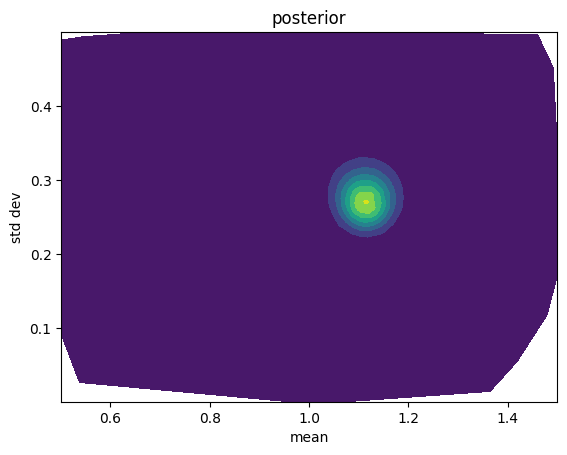

In [7]:
fig, ax = plt.subplots()

ax.tricontourf(parameters[:, 0], parameters[:, 1], posterior, extent=[0.5, 1.5, 0.5, 0])
# ax.scatter(mu_true,sigma_true,marker="o", color="r", s=5)
ax.set_xlabel("mean")
ax.set_ylabel("std dev")
ax.set_title("posterior")

Text(0.5, 1.0, 'posterior')

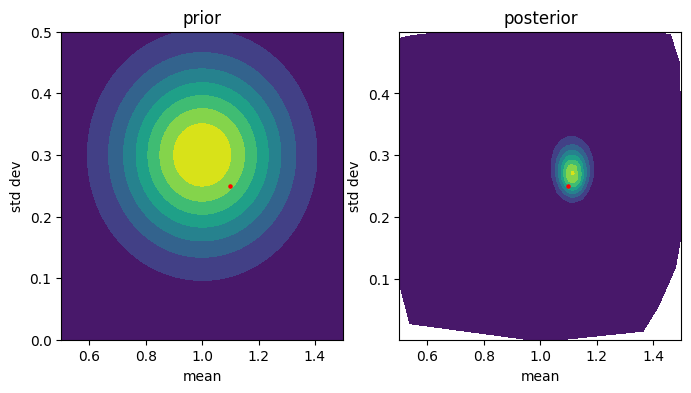

In [8]:
#%matplotlib widget
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].tricontourf(Mu.flatten(),Sigma.flatten(),prior_pdf.flatten(), extent=[0.5,1.5,0.5,0])
ax[1].tricontourf(parameters[:,0], parameters[:,1], posterior, extent=[0.5,1.5,0.5,0])
ax[0].scatter(mu_true,sigma_true,marker="o", color="r", s=5)
ax[1].scatter(mu_true,sigma_true,marker="o", color="r", s=5)
ax[0].set_xlabel("mean")
ax[1].set_xlabel("mean")
ax[0].set_ylabel("std dev")
ax[1].set_ylabel("std dev")
ax[0].set_title("prior")
ax[1].set_title("posterior")

As you can see, we have narrowed down the parameters of the model to be much closer to the "true" parameters of the PDF that produced the data (the red dot). With more data $\mathbf{D}$ this should narrow futher.

### Coin Toss Example

A villain tosses a coin, and we see 78 heads in 100 tosses. We wish to estimate the posterior based on this data.

The unknown parameter here is $\theta$ the probability of the coin landing on heads. In a fair coin, $\theta =0.5$, but here it is unknown.

We will take as our prior (our guess at possible values of $\theta$) the Beta distribution for a variable $\theta$: $$\mathrm{Beta}(\theta, a, b) = \frac{\Gamma(a+b)\theta^{a-1}(1-\theta)^{b-1}}{\Gamma(a)\Gamma(b)}.$$ We will take both $a=b=10$.

Our likelihood is the Binomial distribution $$B(k,n,\theta) = \begin{pmatrix}n\\k\end{pmatrix}\theta^k (1-\theta)^{n-k},$$ for $\theta$ the probability of heads, $n$ the number of trials and $k$ the number of heads. In our case using our data means setting $k=H$. Using the properties that $\begin{pmatrix}n\\k\end{pmatrix}=\frac{n!}{k!(n-k)!}$ and $n! = \Gamma(n+1)$, along with $$\int_0^1 \theta^x(1-\theta)^y\mathrm{d}\theta = \frac{\Gamma(x)\Gamma(y)}{\Gamma(x+y)},$$ we can show that $$p(\theta|H) = \frac{\mathcal{L}(H|\theta)p(\theta)}{\int_0^1\mathcal{L}(H|\theta)p(\theta)\mathrm{d}\theta}=\mathrm{Beta}(\theta, H+a, n-H+b),$$ where $\mathcal{L}(H|\theta) = B(H,n,\theta)$ and $p(\theta)=\mathrm{Beta}(\theta, a, b)$.

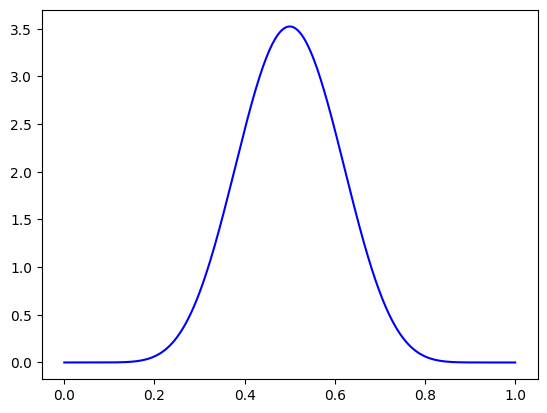

In [9]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Specify the total number of tosses
n = 100

# Specify the observed number of heads
H = 78

# Let’s set up the prior
alpha, beta = 10, 10
prior = stats.beta(alpha, beta)

theta = np.linspace(0, 1, 1000)
# plot PDF of prior
plt.figure()
plt.plot(theta, prior.pdf(theta), label="Prior", c="blue")

Our likelihood function can be obtained from the analytic form derived.

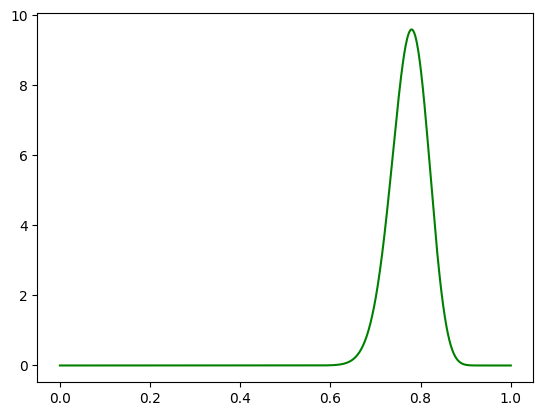

In [10]:
theta = np.linspace(0, 1, 1000)
# plot PDF of prior
plt.figure()
plt.plot(theta, n * stats.binom(n, theta).pmf(H), label="Likelihood", c="green")

And using the derived posterior,

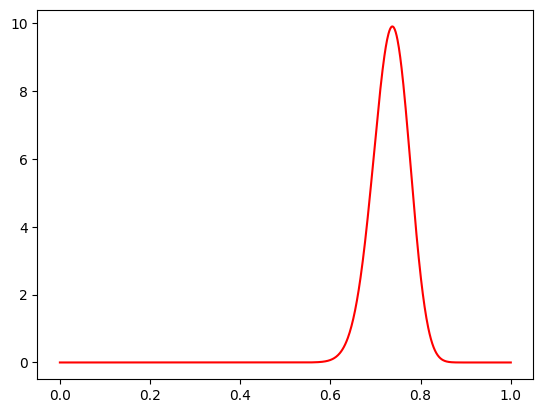

In [11]:
theta = np.linspace(0, 1, 1000)
posterior = stats.beta(H + alpha, n - H + beta)

# plot PDF of prior
plt.figure()
plt.plot(theta, posterior.pdf(theta), label="Posterior", c="red")

All together,

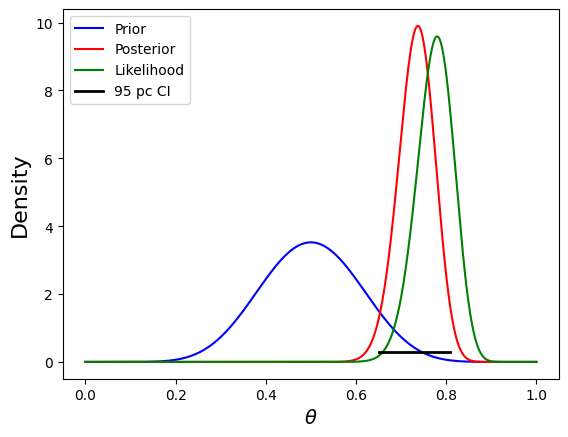

In [12]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Specify the total number of tosses
n = 100

# Specify the observed number of heads
H = 78

# Let’s set up the prior
alpha, beta = 10, 10
prior = stats.beta(alpha, beta)

# define posterior
posterior = stats.beta(H + alpha, n - H + beta)

# calculate a 95 per cent posterior credible interval
ci = posterior.interval(0.95)

# Now let’s do some plotting
theta = np.linspace(0, 1, 1000)
# plot PDF of prior
plt.figure()
plt.plot(theta, prior.pdf(theta), label="Prior", c="blue")
# plot pdf of posterior
plt.plot(theta, posterior.pdf(theta), label="Posterior", c="red")
# plot likelihood
plt.plot(theta, n * stats.binom(n, theta).pmf(H), label="Likelihood", c="green")
# plot 95 per cent credible interval
plt.plot(ci, [0.3, 0.3], c="black", linewidth=2, label="95 pc CI")
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.legend(loc="upper left")
plt.show()

How to read the posterior: 

According to Bayes' theorem, based on the information we gave (the prior) and the information obtained from the data (the likelihood), the probability that the "true" underlying distribution that was used to obtain the data has a parameter of $\theta$ is given by the posterior. So for example, 

In [13]:
print("Probability that theta < 0.7       = ", round(posterior.cdf(0.7), 2))
print("Probability that theta > 0.8       = ", round(1 - posterior.cdf(0.8), 2))
print(
    "Probability that 0.6 < theta < 0.9 = ",
    round(posterior.cdf(0.8) - posterior.cdf(0.7), 2),
)

Probability that theta < 0.7       =  0.2
Probability that theta > 0.8       =  0.04
Probability that 0.6 < theta < 0.9 =  0.76


##### Exercise 5.1

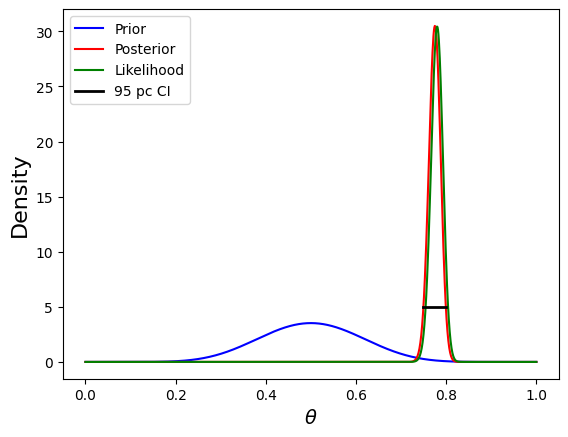

In [14]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Specify the total number of tosses
n = 1000

# Specify the observed number of heads
H = 780

# Let’s set up the prior
alpha, beta = 10, 10
prior = stats.beta(alpha, beta)

# define posterior
posterior = stats.beta(H + alpha, n - H + beta)

# calculate a 95 per cent posterior credible interval
ci = posterior.interval(0.95)

# Now let’s do some plotting
theta = np.linspace(0, 1, 1000)
# plot PDF of prior
plt.figure()
plt.plot(theta, prior.pdf(theta), label="Prior", c="blue")
# plot pdf of posterior
plt.plot(theta, posterior.pdf(theta), label="Posterior", c="red")
# plot likelihood
plt.plot(theta, n * stats.binom(n, theta).pmf(H), label="Likelihood", c="green")
# plot 95 per cent credible interval
plt.plot(ci, [5, 5], c="black", linewidth=2, label="95 pc CI")
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.legend(loc="upper left")
plt.show()

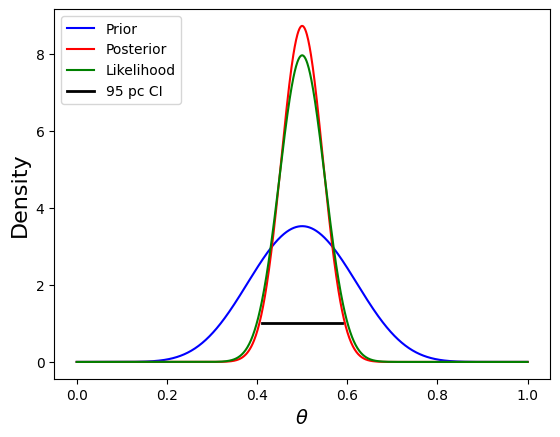

In [15]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Specify the total number of tosses
n = 100

# Specify the observed number of heads
H = 50

# Let’s set up the prior
alpha, beta = 10, 10
prior = stats.beta(alpha, beta)

# define posterior
posterior = stats.beta(H + alpha, n - H + beta)

# calculate a 95 per cent posterior credible interval
ci = posterior.interval(0.95)

# Now let’s do some plotting
theta = np.linspace(0, 1, 1000)
# plot PDF of prior
plt.figure()
plt.plot(theta, prior.pdf(theta), label="Prior", c="blue")
# plot pdf of posterior
plt.plot(theta, posterior.pdf(theta), label="Posterior", c="red")
# plot likelihood
plt.plot(theta, n * stats.binom(n, theta).pmf(H), label="Likelihood", c="green")
# plot 95 per cent credible interval
plt.plot(ci, [1, 1], c="black", linewidth=2, label="95 pc CI")
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.legend(loc="upper left")
plt.show()

We see the resultant posterior much more closely aligned to the likelihood function, as the large amount of data overrides the initial prior, and the likelihood has a much tighter peak around the identified parameter.

##### Exercise 5.2

(np.float64(0.41106985325434225), np.float64(0.5889301467456578))


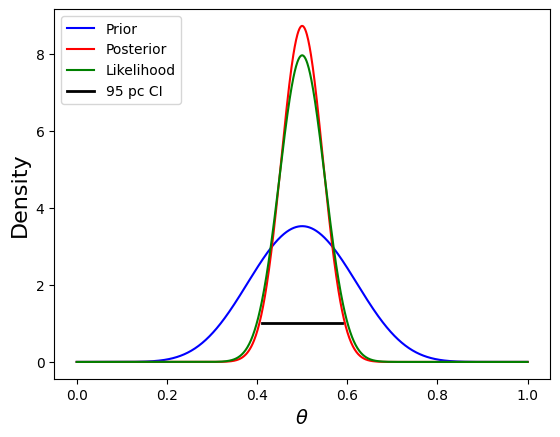

In [16]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Specify the total number of tosses
n = 100

# Specify the observed number of heads
H = 50

# Let’s set up the prior
alpha, beta = 10, 10
prior = stats.beta(alpha, beta)

# define posterior
posterior = stats.beta(H + alpha, n - H + beta)

# calculate a 95 per cent posterior credible interval
ci = posterior.interval(0.95)
print(ci)

# Now let’s do some plotting
theta = np.linspace(0, 1, 1000)
# plot PDF of prior
plt.figure()
plt.plot(theta, prior.pdf(theta), label="Prior", c="blue")
# plot pdf of posterior
plt.plot(theta, posterior.pdf(theta), label="Posterior", c="red")
# plot likelihood
plt.plot(theta, n * stats.binom(n, theta).pmf(H), label="Likelihood", c="green")
# plot 95 per cent credible interval
plt.plot(ci, [1, 1], c="black", linewidth=2, label="95 pc CI")
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.legend(loc="upper left")
plt.show()

We see as the likelihood function agrees with the prior, the posterior becomes much more tightly peaked around the centre of the prior as the model becomes more confident in the underlying parameter.

### Sampling

We now use a grid sampling (1D grid = line of points) to estimate our posterior, in case we didn't know it analytically.

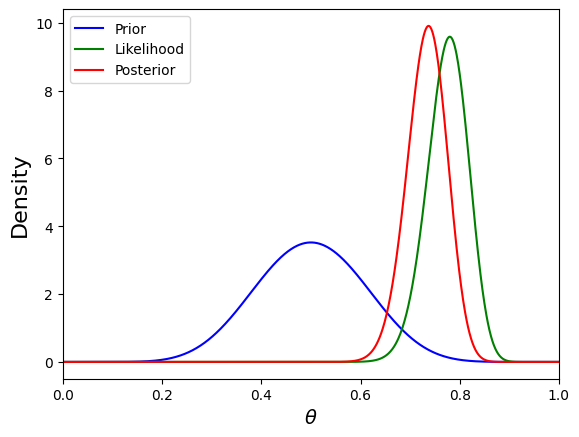

In [17]:
H = 78
n = 100
# Define grid of theta values (a 1D grid = points along a line...)
theta = np.linspace(0, 1, 1000)
prior = stats.beta(alpha, beta)
# calculate posterior at each theta value
sampled_posterior = prior.pdf(theta) * stats.binom(n, theta).pmf(H)
# Normalise to one so volume is 1
sampled_posterior /= sampled_posterior.sum() / len(theta)
# plot the prior
plt.figure()
plt.plot(theta, prior.pdf(theta), label="Prior", c="blue")
# plot the likelihood
plt.plot(theta, n * stats.binom(n, theta).pmf(H), label="Likelihood", c="green")
# plot the posterior
plt.plot(theta, sampled_posterior, label="Posterior", c="red")
plt.xlim([0, 1])
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.legend()
plt.show()

##### Exercise 5.3

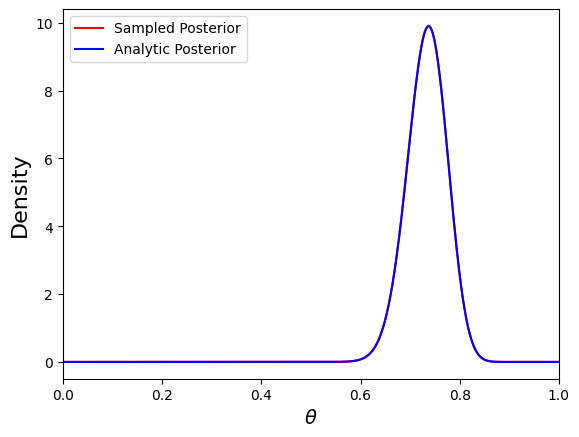

In [18]:
plt.figure()

posterior = stats.beta(H + alpha, n - H + beta)
theta = np.linspace(0, 1, 1000)


plt.plot(theta, sampled_posterior, label="Sampled Posterior", c="red")
plt.plot(theta, posterior.pdf(theta), label="Analytic Posterior", c="blue")

plt.xlim([0, 1])
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.legend()
plt.show()

The two are identical, hence perfectly overlap

##### Exercise 5.4

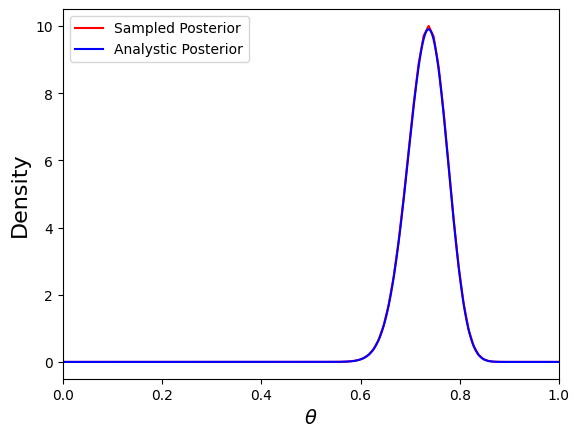

In [19]:
H = 78
n = 100
# Define grid of theta values (a 1D grid = points along a line...)
theta = np.linspace(0, 1, 100)
prior = stats.beta(alpha, beta)
# calculate posterior at each theta value
sampled_posterior = prior.pdf(theta) * stats.binom(n, theta).pmf(H)
# Normalise to one so volume is 1
sampled_posterior /= sampled_posterior.sum() / len(theta)
posterior = stats.beta(H + alpha, n - H + beta)

theta_fine = np.linspace(0, 1, 1000)


plt.figure()


plt.plot(theta, sampled_posterior, label="Sampled Posterior", c="red")
plt.plot(theta_fine, posterior.pdf(theta_fine), label="Analystic Posterior", c="blue")

plt.xlim([0, 1])
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel("Density", fontsize=16)
plt.legend()
plt.show()

The poorer estimate of the sampled posterior affects both the resolution of the curve, and the normalisation due to the evidence/marginal probability in the denominator of each point, hence both a rougher curve and with different values at each point in $\theta$.

### Importance Sampling

We only want to look at "important" values of our model parameters $\theta$ when examining the posterior. Regions where the posterior (i.e. the prior and/or likelihood) are small, known as the tails, tell us very little about the underlying distribution of model parameters.

In 1D, this is easy! If we set appropriate bounds on our parameters, all points lie within the "important" region of our distributions.

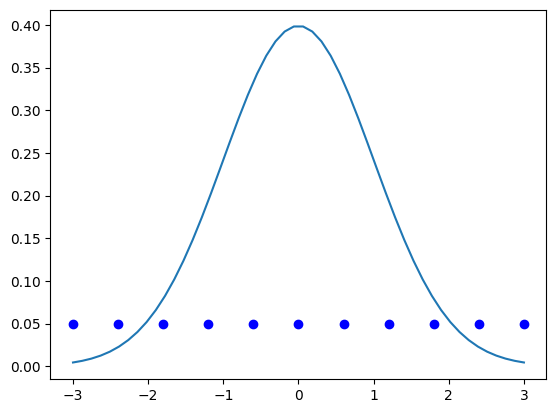

In [20]:
x = np.linspace(-3, 3)
x_grid = np.linspace(-3, 3, 11)

fig, ax = plt.subplots()
ax.plot(x, norm.pdf(x))
ax.scatter(x_grid, 0.05 * np.ones_like(x_grid), c="b")

In 2D this gets a little trickier, as around 25% of points in a grid search will lie in the "unimportant" region for a radially symmetric distribution.

Number of points within circle / total:  81/121
Percentage:  66.9%


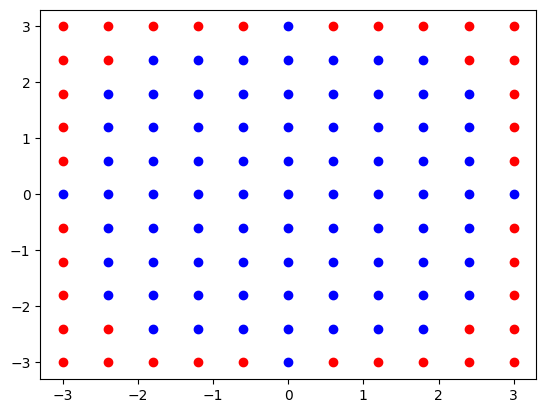

In [21]:
x_grid = np.linspace(-3, 3, 11)
X_grid, Y_grid = np.meshgrid(x_grid, x_grid)

mask = (X_grid**2 + Y_grid**2) <= 3**2

fig, ax = plt.subplots()
ax.scatter(X_grid[mask], Y_grid[mask], c="b")
ax.scatter(X_grid[~mask], Y_grid[~mask], c="r")

print(
    "Number of points within circle / total: ",
    f"{sum(mask.flatten())}/{len(mask.flatten())}",
)
print("Percentage: ", f"{100*sum(mask.flatten())/len(mask.flatten()):.1f}%")

In 3D, this fraction becomes worse. More points lie in the "corners" of the space, away from the "important" region.

Number of points within circle / total:  515/1331
Percentage:  38.7%


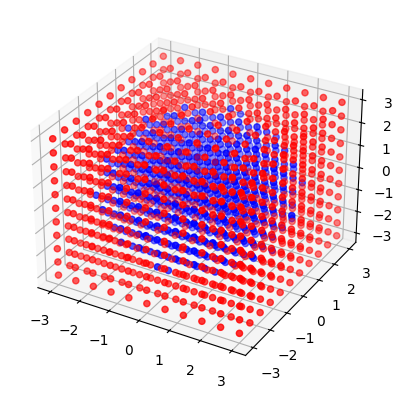

In [22]:
x_grid = np.linspace(-3, 3, 11)
X_grid, Y_grid, Z_grid = np.meshgrid(x_grid, x_grid, x_grid)

mask = (X_grid**2 + Y_grid**2 + Z_grid**2) <= 3**2

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X_grid[mask], Y_grid[mask], Z_grid[mask], c="b")
ax.scatter(X_grid[~mask], Y_grid[~mask], Z_grid[~mask], c="r")

print(
    "Number of points within circle / total: ",
    f"{sum(mask.flatten())}/{len(mask.flatten())}",
)
print("Percentage: ", f"{100*sum(mask.flatten())/len(mask.flatten()):.1f}%")

In ND it's bad...

In [23]:
n_dim = 6

x_grid = np.linspace(-3, 3, 11)
X_grid = np.meshgrid(*[x_grid for i in range(n_dim)])

mask = sum([x**2 for x in X_grid]) <= 3**2

print("Number of dimensions: ", n_dim)

print(
    "Number of points within circle / total: ",
    f"{sum(mask.flatten())}/{len(mask.flatten())}",
)
print("Percentage: ", f"{100*sum(mask.flatten())/len(mask.flatten()):.1f}%")

Number of dimensions:  6
Number of points within circle / total:  84253/1771561
Percentage:  4.8%


### Markov Chain Monte Carlo (MCMC)

#### Coin Toss

In [24]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Specify the total number of tosses
n = 100
# Specify the observed number of heads
H = 78
alpha, beta = 10, 10


def posterior(theta, n, H, alpha, beta):
    if theta < 0 or theta > 1:
        return 0
    else:
        likelihood = stats.binom(n, theta).pmf(H)
        prior = stats.beta(alpha, beta).pdf(theta)
        return likelihood * prior

In [25]:
naccepted = 0
theta = 0.5
nsamples = 10000
samples = np.zeros(nsamples + 1)
sigma = 0.3
samples[0] = theta

In [26]:
for i in range(nsamples):
    theta_prime = theta + stats.norm(0, sigma).rvs()
    a = min(
        1,
        posterior(theta_prime, n, H, alpha, beta) / posterior(theta, n, H, alpha, beta),
    )
    u = np.random.uniform()
    if u < a:
        naccepted += 1
        theta = theta_prime
    samples[i + 1] = theta
print("Acceptance efficiency = ", naccepted / nsamples)

Acceptance efficiency =  0.1657


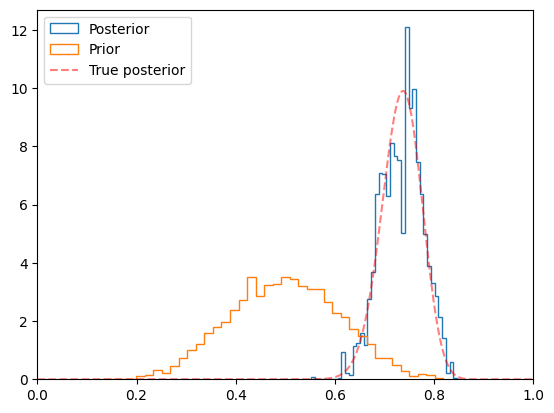

In [27]:
# ‘‘//’’ means ‘‘divide by 2 and round down to nearest whole number’’
burnedinsamples = len(samples) // 2
realposterior = stats.beta(H + alpha, n - H + beta)
theta = np.linspace(0, 1, 1000)
# ‘‘[burnedinsamples:]’’ means start at index=burnedinsamples, and go to the end
plt.figure()
plt.hist(
    samples[burnedinsamples:],
    40,
    histtype="step",
    density=True,
    linewidth=1,
    label="Posterior",
)
plt.hist(
    prior.rvs(len(samples) - burnedinsamples),
    40,
    histtype="step",
    density=True,
    linewidth=1,
    label="Prior",
)
plt.plot(
    theta,
    realposterior.pdf(theta),
    c="red",
    linestyle="--",
    alpha=0.5,
    label="True posterior",
)
plt.xlim([0, 1])
plt.legend(loc="upper left")
plt.show()

##### Exercise 5.5

In [28]:
naccepted = 0
theta = 0.5
nsamples = 10000
samples = np.zeros(nsamples + 1)
sigma = 0.1
samples[0] = theta

In [29]:
for i in range(nsamples):
    theta_prime = theta + stats.norm(0, sigma).rvs()
    a = min(
        1,
        posterior(theta_prime, n, H, alpha, beta) / posterior(theta, n, H, alpha, beta),
    )
    u = np.random.uniform()
    if u < a:
        naccepted += 1
        theta = theta_prime
    samples[i + 1] = theta
print("Acceptance efficiency = ", naccepted / nsamples)

Acceptance efficiency =  0.4256


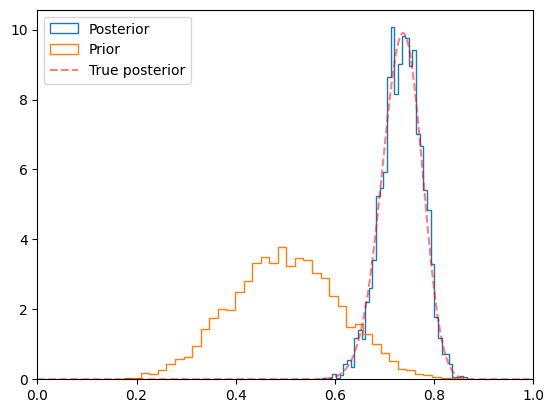

In [30]:
# ‘‘//’’ means ‘‘divide by 2 and round down to nearest whole number’’
burnedinsamples = len(samples) // 2
realposterior = stats.beta(H + alpha, n - H + beta)
theta = np.linspace(0, 1, 1000)
# ‘‘[burnedinsamples:]’’ means start at index=burnedinsamples, and go to the end
plt.figure()
plt.hist(
    samples[burnedinsamples:],
    40,
    histtype="step",
    density=True,
    linewidth=1,
    label="Posterior",
)
plt.hist(
    prior.rvs(len(samples) - burnedinsamples),
    40,
    histtype="step",
    density=True,
    linewidth=1,
    label="Prior",
)
plt.plot(
    theta,
    realposterior.pdf(theta),
    c="red",
    linestyle="--",
    alpha=0.5,
    label="True posterior",
)
plt.xlim([0, 1])
plt.legend(loc="upper left")
plt.show()

The quality of the histogram notably improves, along with the acceptance rate of the Metropolis algorithm. The smaller step sizes seem to result in a more successful run.

### Multimodal Likelihood Function

We are taking $$\mathcal{L}(\mathbf{D}|x_1, x_2)= \sqrt{x_1}\sin(x_1)\times \sqrt{x_2} \sin(x_2) + 10$$

In [31]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm


def likelihood(x1, x2):
    return np.sqrt(x1) * np.sin(x1) * np.sqrt(x2) * np.sin(x2) + 10

In [32]:
x1 = np.arange(0.0, 10.0, 0.1)
x2 = np.arange(0.0, 10.0, 0.1)
X, Y = np.meshgrid(x1, x2)  # grid of points

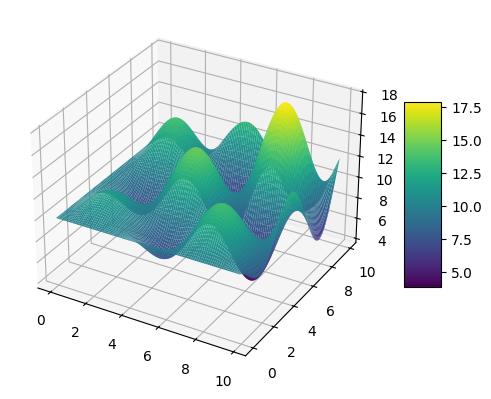

In [33]:
Z = likelihood(X, Y)  # evaluation of the function on the grid
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)
fig.colorbar(surf, shrink=0.5, aspect=5)

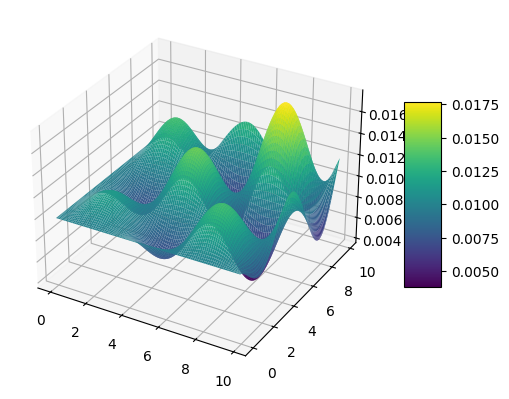

In [34]:
prior = 1.0
sampled_posterior = likelihood(X, Y) * prior
sampled_posterior /= sampled_posterior.sum() / len(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, sampled_posterior, rstride=1, cstride=1, cmap=cm.viridis)
fig.colorbar(surf, shrink=0.5, aspect=5)

In [35]:
from scipy import stats


def posterior(x1, x2):
    if x1 < 0 or x1 > 10 or x2 < 0 or x2 > 10:
        return 0
    else:
        return likelihood(x1, x2) * 1.0


def sampler(nsamples):
    theta = np.array([5.0, 5.0])
    sigma = np.diag([1.0, 1.0])

    x1_samples = np.zeros(nsamples + 1)
    x2_samples = np.zeros(nsamples + 1)
    samples = np.zeros((nsamples + 1, 2), float)
    samples[0] = theta

    for i in range(nsamples):
        theta_prime = stats.multivariate_normal(theta, sigma).rvs()
        a = min(posterior(*theta_prime) / posterior(*theta), 1)
        if np.random.rand() < a:
            theta = theta_prime
        samples[i + 1] = theta

    return samples

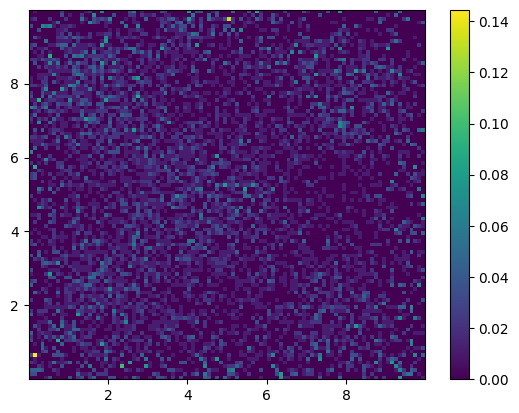

In [36]:
samples = sampler(10000)

burnedinsamples = 1000
fig, ax = plt.subplots()
plot_hist = ax.hist2d(
    samples[burnedinsamples:, 0], samples[burnedinsamples:, 1], bins=100, density=True
)
cb = plt.colorbar(plot_hist[3], ax=ax)

# plt.show()

##### Exercise 5.6

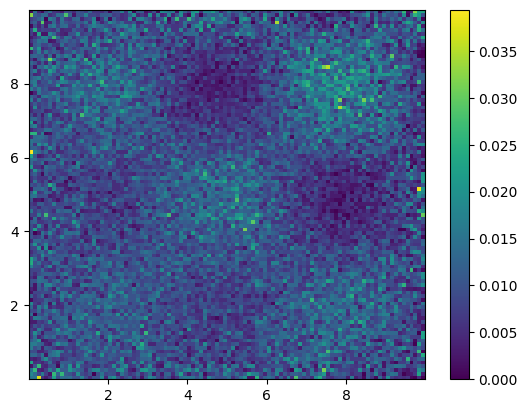

In [37]:
samples = sampler(10**5)

burnedinsamples = 1000
fig, ax = plt.subplots()
plot_hist = ax.hist2d(
    samples[burnedinsamples:, 0], samples[burnedinsamples:, 1], bins=100, density=True
)
cb = plt.colorbar(plot_hist[3], ax=ax)

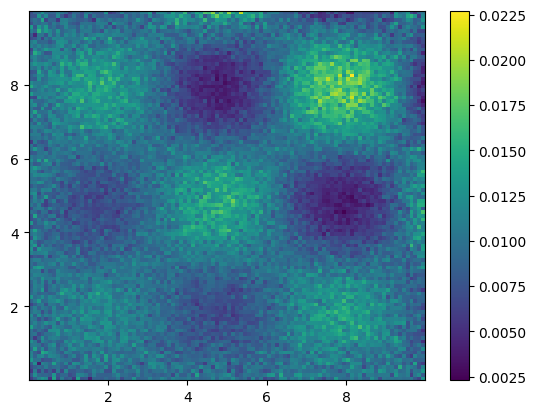

In [38]:
samples = sampler(10**6)

burnedinsamples = 1000
fig, ax = plt.subplots()
plot_hist = ax.hist2d(
    samples[burnedinsamples:, 0], samples[burnedinsamples:, 1], bins=100, density=True
)
cb = plt.colorbar(plot_hist[3], ax=ax)

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, MaxNLocator
from scipy.interpolate import make_interp_spline


def makeHistogramPlot(
    xdata,
    ydata,
    xlims=None,
    ylims=None,
    nxbins=50,
    nybins=50,
    nbins=50,
    style="hist",
    width=9,
    height=9,
    ratio=4,
):
    # Define the x and y data
    x = xdata
    y = ydata
    # Set up default x and y limits

    if xlims == None:
        xlims = [min(x), max(x)]
    if ylims == None:
        ylims = [min(y), max(y)]
    # Set up your x and y labels
    xlabel = "$x_1$"
    ylabel = "$x_2$"
    mtitle = ""
    # Define the locations for the axes
    left, width = 0.12, 0.55
    bottom, height = 0.12, 0.55
    bottom_h = left_h = left + width + 0.02
    # Set up the size of the figure
    fig = plt.figure(figsize=(9, 9))
    gs = fig.add_gridspec(
        2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0, wspace=0
    )
    ax = gs.subplots(
        sharex="col",
        sharey="row",
    )
    fig.delaxes(ax[0, 1])

    # Make the three plots
    axData = ax[1, 0]  # plt.axes(rect_data)  # main plot
    axHistx = ax[0, 0]  # plt.axes(rect_histx)  # x histogram
    axHisty = ax[1, 1]  # plt.axes(rect_histy)  # y histogram

    # for ax in [axData,  axHistx, axHisty]:
    #     ax.label_outer()

    axHistx.set_axis_off()
    axHisty.set_axis_off()
    # Remove the inner axes numbers of the histograms
    # nullfmt = NullFormatter()
    # axHistx.xaxis.set_major_formatter(nullfmt)
    # axHisty.yaxis.set_major_formatter(nullfmt)
    # Find the min/max of the data
    xmin = min(xlims)
    xmax = max(xlims)
    ymin = min(ylims)
    ymax = max(ylims)
    # Make the ’main’ plot
    xbins = np.linspace(start=xmin, stop=xmax, num=nxbins + 1, endpoint=True)
    ybins = np.linspace(start=ymin, stop=ymax, num=nybins + 1, endpoint=True)
    xcenter = (xbins[1:] + xbins[:-1]) / 2.0
    ycenter = (ybins[1:] + ybins[:-1]) / 2.0
    H, xedges, yedges = np.histogram2d(y, x, bins=(ybins, xbins))
    X = xcenter
    Y = ycenter
    Z = H
    # Plot the temperature data
    cax = axData.imshow(
        H,
        extent=[xmin, xmax, ymin, ymax],
        interpolation="nearest",
        origin="lower",
        aspect="auto",
    )

    # Plot the axes labels
    axData.set_xlabel(xlabel, fontsize=25)
    axData.set_ylabel(ylabel, fontsize=25)
    # Make the tickmarks pretty
    ticklabels = axData.get_xticklabels()
    for label in ticklabels:
        label.set_fontsize(18)
        label.set_family("serif")
        ticklabels = axData.get_yticklabels()
    for label in ticklabels:
        label.set_fontsize(18)
        label.set_family("serif")
    # Set up the plot limits
    axData.set_xlim(xlims)
    axData.set_ylim(ylims)
    # Set up the histogram bins
    xbins = np.linspace(xmin, xmax, nbins + 1, endpoint=True)
    ybins = np.linspace(ymin, ymax, nbins + 1, endpoint=True)
    # Plot the histograms

    xHist, xEdges = np.histogram(x, bins=xbins, density=True)
    yHist, yEdges = np.histogram(y, bins=ybins, density=True)

    # axHistx.hist(x, bins=xbins, color="blue", fill=False, density=True, histtype="step")
    # axHisty.hist(
    #     y, bins=ybins, orientation="horizontal", color="red", fill=False, density=True, histtype="step"
    # )
    if style == "step":
        axHistx.stairs(xHist, xEdges, baseline=None, linewidth=2)
        axHisty.stairs(
            yHist, yEdges, orientation="horizontal", baseline=None, linewidth=2
        )
    elif style == "hist":
        xCentres = (xEdges[1:] + xEdges[:-1]) / 2
        yCentres = (yEdges[1:] + yEdges[:-1]) / 2
        axHistx.bar(xCentres, xHist, xEdges[1:] - xEdges[:-1], fill=None)
        axHisty.barh(
            yCentres, yHist, yEdges[1:] - yEdges[:-1], fill=None
        )  # , orientation="horizontal"

    elif style == "smooth":
        xCentres = (xEdges[1:] + xEdges[:-1]) / 2
        yCentres = (yEdges[1:] + yEdges[:-1]) / 2
        xSmooth = make_interp_spline(xCentres, xHist)
        ySmooth = make_interp_spline(yCentres, yHist)
        xLin = np.linspace(min(xCentres), max(xCentres), 501, endpoint=True)
        yLin = np.linspace(min(yCentres), max(yCentres), 501, endpoint=True)
        axHistx.plot(xLin, xSmooth(xLin))
        axHisty.plot(
            ySmooth(yLin),
            yLin,
        )  # , orientation="horizontal"

    axHistx.set_ylim((0, 1.1 * max(xHist)))
    axHisty.set_xlim((0, 1.1 * max(yHist)))
    # Make the tickmarks pretty
    ticklabels = axData.get_yticklabels()
    for label in ticklabels:
        label.set_fontsize(12)
        label.set_family("serif")
    # Make the tickmarks pretty
    ticklabels = axData.get_xticklabels()
    for label in ticklabels:
        label.set_fontsize(12)
        label.set_family("serif")
    # Cool trick that changes the number of tickmarks for the histogram axes
    axData.xaxis.set_major_locator(MaxNLocator(5, prune="both"))
    axData.yaxis.set_major_locator(MaxNLocator(5, prune="both"))

    print(yCentres[-1] + (yEdges[1:] - yEdges[:-1])[-1] / 2)
    print(xCentres[-1] + (xEdges[1:] - xEdges[:-1])[-1] / 2)

    fig.tight_layout()
    return fig

10.0
10.0


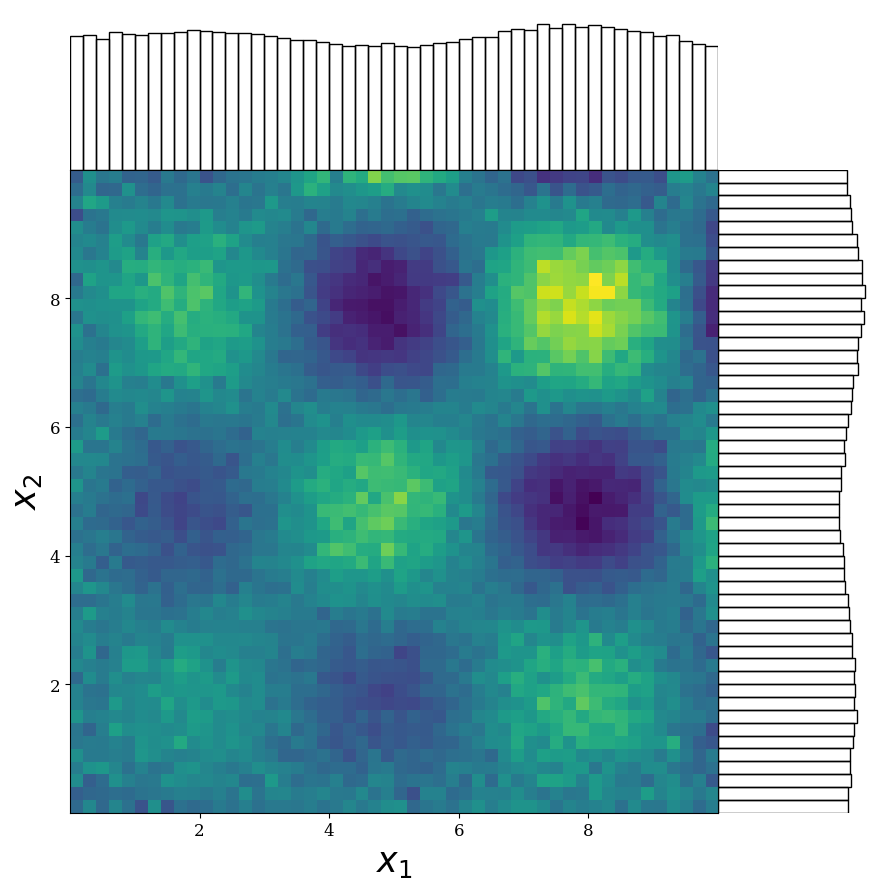

In [40]:
fig = makeHistogramPlot(
    samples[burnedinsamples:, 0],
    samples[burnedinsamples:, 1],
    xlims=(0, 10),
    ylims=(0, 10),
    style="hist",
)
# fig.show()

##### Exercise 5.7

9.999938735150764
9.99996849856965


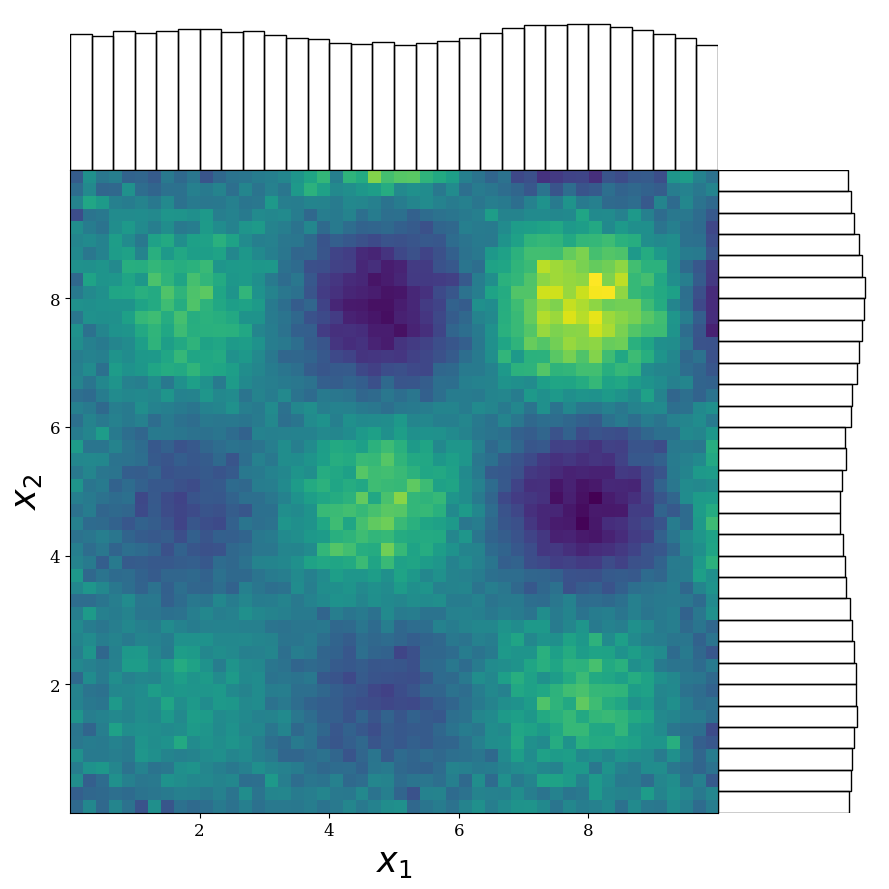

In [41]:
fig = makeHistogramPlot(
    samples[burnedinsamples:, 0],
    samples[burnedinsamples:, 1],
    nxbins=50,
    nybins=50,
    nbins=30,
)

##### Exercise 5.8

In [42]:
def likelihood(theta):
    mean1 = np.array([5.0, 5.0, 5.0, 5.0])
    sigma1 = np.array(np.diag([0.2, 0.1, 0.4, 0.6]))
    mean2 = np.array([7.0, 7.0, 7.0, 7.0])
    sigma2 = np.array(np.diag([1.0, 1.0, 1.0, 1.0]))
    return stats.multivariate_normal.pdf(
        theta, mean1, sigma1
    ) + stats.multivariate_normal.pdf(theta, mean2, sigma2)


def prior(theta):
    return np.all(np.logical_and(theta >= 0, theta <= 10))


def posterior(theta):
    return likelihood(theta) * prior(theta)

Going from scratch:

In [43]:
def sampler(func, n_samples, starting_point):
    theta = starting_point
    samples = np.empty((n_samples, len(starting_point)))

    sigma = np.diag([1] * len(starting_point))

    for i in range(n_samples):
        proposed_theta = stats.multivariate_normal.rvs(theta, cov=sigma)
        a = min(func(proposed_theta) / func(theta), 1)
        if np.random.rand() < a:
            theta = proposed_theta
        samples[i] = theta
    return samples

In [44]:
n_samples = 10**5
samples = sampler(posterior, n_samples, np.array([5.0, 5.0, 5.0, 5.0]))

9.998248760537937
9.995381556927175


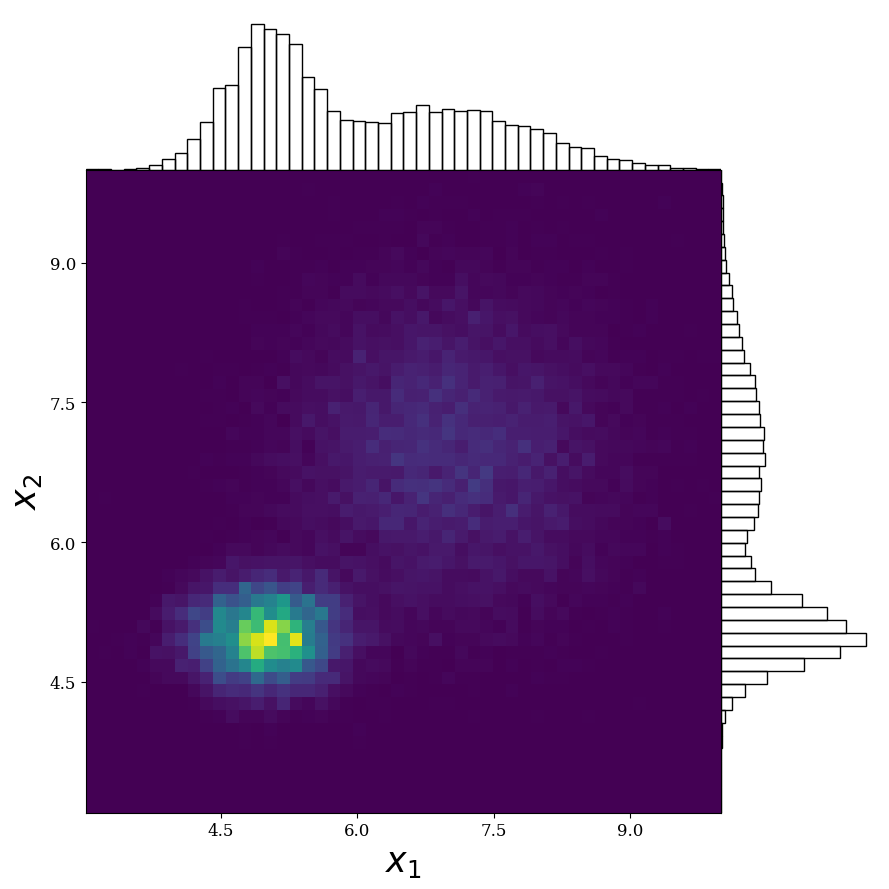

In [45]:
burnedinsamples = 1000

fig = makeHistogramPlot(
    samples[burnedinsamples:, 0],
    samples[burnedinsamples:, 1],
    nxbins=50,
    nybins=50,
    nbins=50,
)

9.987504912387152
9.989523653083062


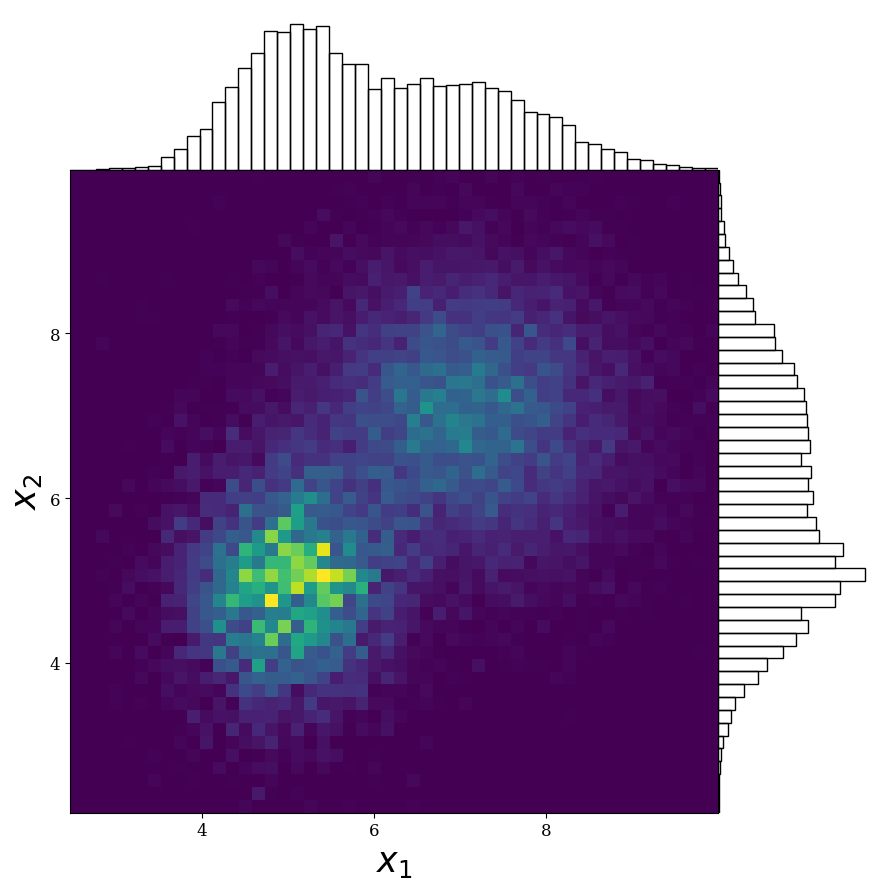

In [46]:
burnedinsamples = 1000

fig = makeHistogramPlot(
    samples[burnedinsamples:, 2],
    samples[burnedinsamples:, 3],
    nxbins=50,
    nybins=50,
    nbins=50,
)

## Frequentist

##### Exercise 5.9

Consider the log-likelihood $$\ln \mathcal{L} = C + H\ln(\theta) + (n-H)\ln(1-\theta)$$

The derivative of this function w.r.t $\theta$ is $$\frac{\partial}{\partial \theta} \ln \mathcal{L} = \frac{H}{\theta} - \frac{n-H}{1-\theta}$$

Looking for the stable point in $\ln \mathcal{L}$ means $\frac{\partial}{\partial\theta}\ln\mathcal{L}=0$: $$\frac{H}{\theta} = \frac{n-H}{1-\theta}$$ $$\implies H-H\theta = n\theta -H\theta,$$ provided $\theta\neq 0,1$, $$\implies \theta = \frac{H}{n}.$$  

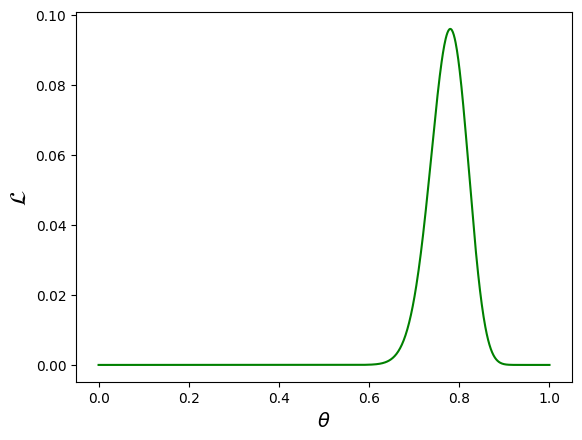

In [47]:
import matplotlib.pyplot as plt


def likelihood(theta):
    n = 100
    H = 78
    return stats.binom(n, theta).pmf(H)


theta = np.linspace(0, 1, 1000)
plt.figure()
plt.plot(theta, likelihood(theta), label="Likelihood", c="green")
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel(r"$\mathcal{L}$", fontsize=16)
plt.show()

##### Exercise 5.10

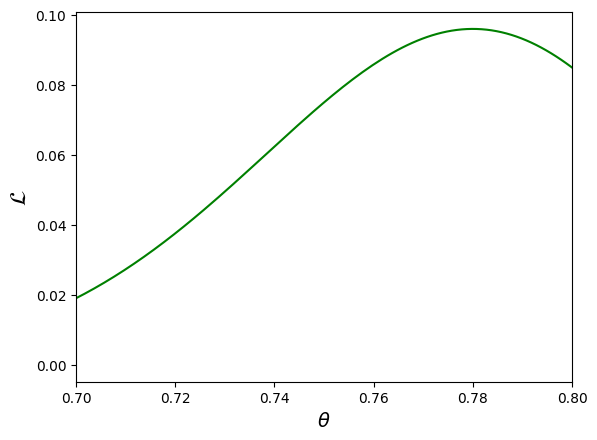

In [48]:
plt.figure()
plt.plot(theta, likelihood(theta), label="Likelihood", c="green")
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel(r"$\mathcal{L}$", fontsize=16)
plt.xlim(0.7, 0.8)
plt.show()

The peak occurs at $$0.78 = \frac{78}{100}=\frac{H}{n}$$ as expected.

In [49]:
def minuslogL(theta):
    H = 78
    n = 100
    return -1 * (H * np.log(theta) + (n - H) * np.log(1 - theta))

In [50]:
import scipy.optimize as opt

theta_initial = 0.5
results = opt.minimize(minuslogL, x0=np.array(theta_initial), bounds=[(0.0001, 0.9999)])
# print("Solution: x=%f" % results.x)
print(f"Solution: x = {results.x[0]:.3f}")

Solution: x = 0.780


In [51]:
def minusLogLikelihood(x):
    return -1 * np.log(np.sqrt(x[0]) * np.sin(x[0]) * np.sqrt(x[1]) * np.sin(x[1]) + 10)

(0.0, 10.0)

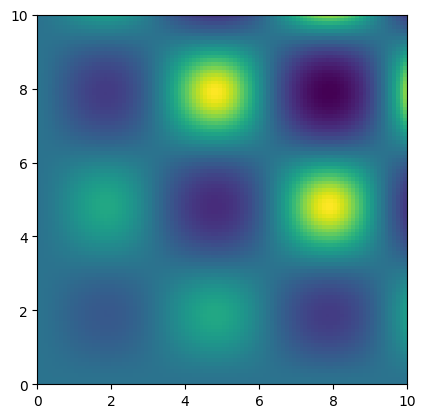

In [52]:
x = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, x)
theta = np.empty((2, len(x), len(x)))
theta[0] = X
theta[1] = Y

mLL = minusLogLikelihood(theta)
fig, ax = plt.subplots()
ax.imshow(mLL, extent=[0, 10, 10, 0])
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

In [53]:
brute = opt.brute(minusLogLikelihood, ranges=[(0.0001, 9.9999), (0.0001, 9.9999)])
print(brute)

[7.91706759 7.91700497]


##### Exercise 5.11

In [54]:
minimum = opt.minimize(
    minusLogLikelihood, x0=(1, 1), bounds=[(0.0001, 9.9999), (0.0001, 9.9999)]
)
print(minimum.x)

[1.83654147 1.83654141]


This is **not** the global minimum of the log likelihood on the bounds considered. The minimisation function has found a local minimum and become stuck.

##### Exercise 5.12

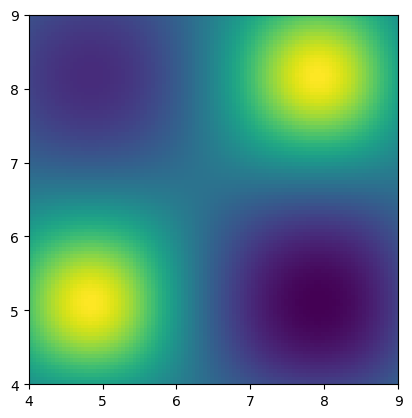

In [55]:
x = np.linspace(4, 9, 100)
X, Y = np.meshgrid(x, x)
theta = np.empty((2, len(x), len(x)))
theta[0] = X
theta[1] = Y

mLL = minusLogLikelihood(theta)
fig, ax = plt.subplots()
ax.imshow(mLL, extent=[4, 9, 4, 9])

In [56]:
minimum = opt.minimize(
    minusLogLikelihood, x0=(5, 5), bounds=[(0.0001, 9.9999), (0.0001, 9.9999)]
)
print(minimum.x)

minimum = opt.minimize(
    minusLogLikelihood, x0=(8, 8), bounds=[(0.0001, 9.9999), (0.0001, 9.9999)]
)
print(minimum.x)

[4.81583985 4.81583985]
[7.91705292 7.91705292]


We again see that the minimisation function has gotten stuck in the local minimum at $(4.8,4.8)$ in the first case, only finding the global maximum in the second case by beginning close to the target. 

##### Exercise 5.13

The differential evolution algorithm takes a random span of initial points across the bounds of the problem in order to find the global minimum. Thus, an initial guess is not required.

##### Exercise 5.14

In [57]:
from scipy.optimize import differential_evolution, LinearConstraint, rosen
import numpy as np


# Ignore this, this is just for the animation in the next cell
class callback:
    def __init__(self, FN):
        self.FN = FN
        self.pop = []

    def __call__(self, intermediate_result):
        self.pop.append(intermediate_result.population)
        # np.testing.assert_equal(xk, self.FN.best_x)
        # print(self.FN.best_x, self.FN.minf)


C = callback(minusLogLikelihood)

# Ignore the above

results = opt.differential_evolution(
    minusLogLikelihood, bounds=[(0.0001, 9.9999), (0.0001, 9.9999)], callback=C
)

print(results.x)

[7.91705275 7.91705275]


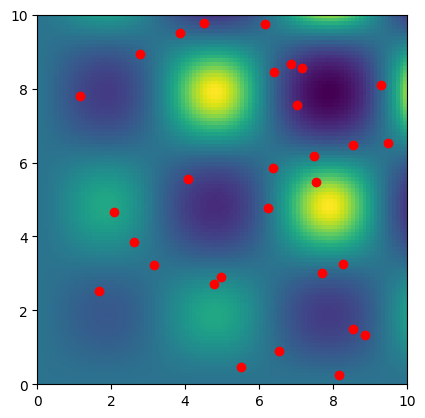

In [58]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.close("all")


x = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, x)
theta = np.empty((2, len(x), len(x)))
theta[0] = X
theta[1] = Y

mLL = minusLogLikelihood(theta)
fig, ax = plt.subplots()
ax.imshow(mLL, extent=[0, 10, 10, 0])

ax.set_ylim(0, 10)

scatt = ax.scatter(C.pop[0][:, 0], C.pop[0][:, 1], c="r")


def animate(i):
    ax.clear()
    hist = ax.imshow(mLL, extent=[0, 10, 10, 0])
    ax.set_ylim(0, 10)

    scatt = ax.scatter(C.pop[i][:, 0], C.pop[i][:, 1], c="r")
    # scatt.set_offsets((C.pop[i][:,0]-C.pop[0][:,0], C.pop[i][:,1]-C.pop[0][:,1]))
    return scatt, hist


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=results.nit, interval=500
)
writer = animation.PillowWriter(fps=2, metadata=dict(artist="Me"), bitrate=1800)
ani.save("scatter.gif", writer=writer)

The above demonstrates the algorithm in action, showing the population vectors at each iteration of the algorithm. The points linger slightly in each local minimum before converging on the global minimum.

### Bootstrapping

The following 4 cells show the process we apply for each "round" of the experiment. 100 coins are flipped and the results recorded, with the MLE of the 

In [59]:
from numpy import random


def flip(p):
    return "H" if random.random() < p else "T"

In [60]:
N = 100
flips = [flip(0.78) for i in range(N)]
print("Number of heads is: ", flips.count("H"))

Number of heads is:  80


In [61]:
def minuslogL(theta, n, H):
    return -1 * (H * np.log(theta) + (n - H) * np.log(1 - theta))

In [62]:
import scipy.optimize as opt

theta_initial = 0.5
num_heads = flips.count("H")

results = opt.minimize(
    minuslogL,
    x0=np.array(theta_initial),
    args=(N, num_heads),
    bounds=[(0.0001, 0.9999)],
)
print("Number of heads: ", num_heads, ", MLE: ", round(results.x[0], 2))

Number of heads:  80 , MLE:  0.8


##### Exercise 5.15

In [63]:
import numpy as np

n_runs = 10**4
N = 100
p = 0.78

results = np.empty((n_runs))
for i in range(n_runs):
    flips = [flip(p) for i in range(N)]
    num_heads = flips.count("H")
    fit = opt.minimize(
        minuslogL,
        x0=np.array(theta_initial),
        args=(N, num_heads),
        bounds=[(0.01, 0.99)],
        # tol=1e-10 #fixes strange binning effects in hist, not necessary
    )
    results[i] = fit.x[0]

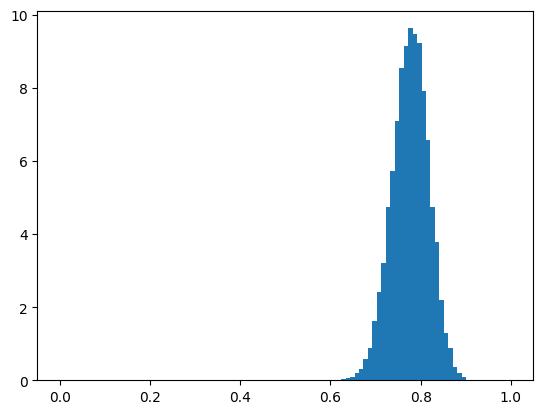

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist = ax.hist(results, bins=np.arange(0, 1, 0.0099), density=True)

##### Exercise 5.16

In [65]:
heads_data = np.full(78, "H")
tails_data = np.full(22, "T")
obs_data = np.concatenate((heads_data, tails_data))
np.random.shuffle(obs_data)  # not necessary for the following steps
print(obs_data)

['T' 'H' 'H' 'T' 'H' 'T' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'H' 'H' 'H' 'H' 'H'
 'T' 'H' 'T' 'H' 'H' 'H' 'H' 'H' 'T' 'H' 'H' 'T' 'H' 'H' 'T' 'H' 'H' 'H'
 'H' 'H' 'T' 'T' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'T' 'H' 'H' 'H' 'T' 'T'
 'H' 'H' 'H' 'H' 'T' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'T' 'T' 'H' 'H' 'H' 'T' 'H' 'H' 'H' 'H' 'H' 'H' 'T'
 'H' 'H' 'T' 'H' 'H' 'H' 'T' 'H' 'H' 'T']


In [66]:
n_boot = 10**4

bootstraps = np.empty((n_boot))
for i in range(n_boot):

    tmp = np.random.choice(obs_data, 100, replace=True)

    num_heads = np.sum(tmp == "H")

    fit = opt.minimize(
        minuslogL,
        x0=np.array(theta_initial),
        args=(N, num_heads),
        bounds=[(0.01, 0.99)],
        # tol=1e-10 #fixes strange binning effects in hist, not necessary
    )
    bootstraps[i] = fit.x[0]

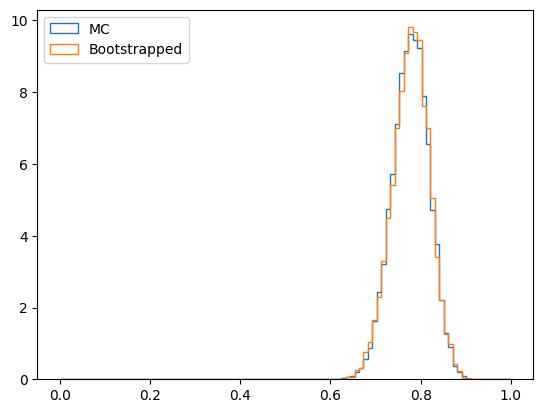

In [67]:
fig, ax = plt.subplots()
ax.hist(
    results,
    bins=np.arange(0, 1, 0.0099),
    density=True,
    fill=False,
    histtype="step",
    label="MC",
)
ax.hist(
    bootstraps,
    bins=np.arange(0, 1, 0.0099),
    density=True,
    fill=False,
    histtype="step",
    label="Bootstrapped",
)
leg = ax.legend()

In [68]:
import scipy.optimize as opt

distribution_dict = {}
for theta_0 in np.arange(0.01, 0.99, 0.01):
    num_experiments = 1000
    theta_tilde_values = np.zeros(num_experiments)
    for experiment in range(num_experiments):
        N = 100
        flips = [flip(theta_0) for i in range(N)]
        num_heads = flips.count("H")
        theta_initial = 0.5
        results = opt.minimize(
            minuslogL,
            x0=np.array(theta_initial),
            args=(N, num_heads),
            bounds=[(0.0001, 0.9999)],
        )
        theta_tilde_values[experiment] = results.x
    distribution_dict[theta_0] = theta_tilde_values

/tmp/ipykernel_536148/3411918043.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_tilde_values[experiment] = results.x


##### Exercise 5.17

In [69]:
import numpy as np
import gammapy_stats as gstats

tilde_theta_bins = np.arange(0.01, 0.99, 0.01)
acceptance_intervals = gstats.fc_construct_acceptance_intervals(
    distribution_dict, tilde_theta_bins, 0.6827
)

In [70]:
theta_0_bins = np.arange(0.01, 0.99, 0.01)
LowerLimitNum, UpperLimitNum, _ = gstats.fc_get_limits(
    theta_0_bins, tilde_theta_bins, acceptance_intervals
)
lower_limit = gstats.fc_find_limit(0.78, LowerLimitNum, tilde_theta_bins)
upper_limit = gstats.fc_find_limit(0.78, UpperLimitNum, tilde_theta_bins)

print(f"{lower_limit:.2f}", f"{upper_limit:.2f}")

0.74 0.83


This is the 68% Confidence Interval

##### Exercise 5.18

In [71]:
tilde_theta_bins = np.arange(0.01, 0.99, 0.01)
acceptance_intervals = gstats.fc_construct_acceptance_intervals(
    distribution_dict, tilde_theta_bins, 0.90
)

theta_0_bins = np.arange(0.01, 0.99, 0.01)
LowerLimitNum, UpperLimitNum, _ = gstats.fc_get_limits(
    theta_0_bins, tilde_theta_bins, acceptance_intervals
)
lower_limit = gstats.fc_find_limit(0.78, LowerLimitNum, tilde_theta_bins)
upper_limit = gstats.fc_find_limit(0.78, UpperLimitNum, tilde_theta_bins)

print(lower_limit, upper_limit)

0.72 0.85


This is the 90% Confidence Interval

In [72]:
num_exp = 10000
theta_tilde_values_boot = np.zeros(num_exp)
N = 100
for boot in range(num_exp):
    sampled = np.random.choice(obs_data, N)
    num_boot_heads = np.count_nonzero(sampled == "H")
    theta_initial = 0.5
    results = opt.minimize(
        minuslogL,
        x0=np.array(theta_initial),
        args=(N, num_boot_heads),
        bounds=[(0.0001, 0.9999)],
    )
    # print("Number of heads: ",num_boot_heads, ", MLE: ",results.x)
    theta_tilde_values_boot[boot] = results.x

/tmp/ipykernel_536148/1023219941.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  theta_tilde_values_boot[boot] = results.x


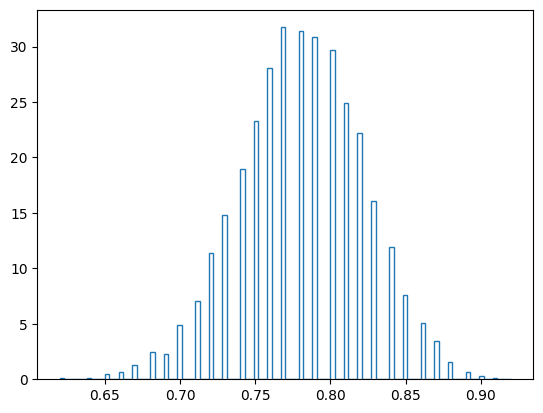

In [73]:
ax = plt.hist(
    theta_tilde_values_boot, bins=100, histtype="step", density=True, linewidth=1
)

##### Exercise 5.19

In [74]:
from scipy import stats

mean = theta_tilde_values_boot.mean()
stddev = theta_tilde_values_boot.std()
print(stats.norm.interval(0.6827, loc=mean, scale=stddev))

(np.float64(0.7390085501197635), np.float64(0.822043430284693))


These are the limits of the 68% confidence interval calculated from the bootstrap derived sampling distribution. There is a small variation in the obtained limits, indicating imprecision due to rounding or statistical fluctuations, and potentially a limitation in the Gaussian assumption of the sampling distribution.

##### Exercise 5.20

In [75]:
print(stats.norm.interval(0.90, loc=mean, scale=stddev))

(np.float64(0.7122373610739071), np.float64(0.8488146193305494))


These values again show some statistical fluctuation away from the limits obtained previously.

As we will see shortly, these values actually closer match the theoretically obtained confidence interval limits than the previously obtained Feldman-Cousins limits.

Text(0, 0.5, '$\\mathcal{L}$')

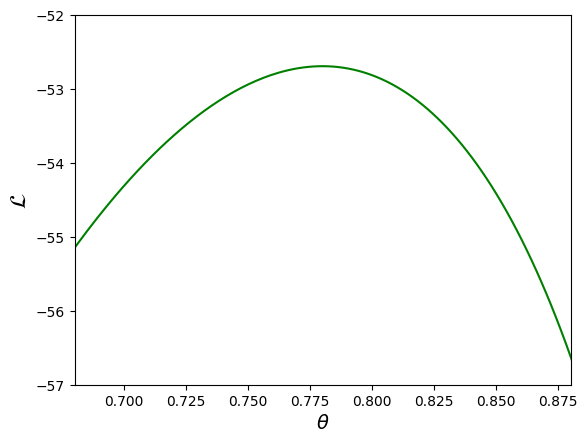

In [76]:
def logL(theta, H):
    n = 100
    return 1 * (H * np.log(theta) + (n - H) * np.log(1 - theta))


theta = np.linspace(0.001, 0.999, 1000)
plt.xlim(0.68, 0.88)
plt.ylim(-57, -52)
logL_values = logL(theta, 78)
plt.plot(
    theta,
    logL_values,
    label="Likelihood",
    c="green",
)
plt.xlabel(r"$\theta$", fontsize=14)
plt.ylabel(r"$\mathcal{L}$", fontsize=16)

In [77]:
print(np.max(logL_values))

-52.69081015246354


##### Exercise 5.21

In [78]:
import scipy.optimize as opt


def logL_value(theta, H, value):
    return logL(theta, H) - value


print(opt.fsolve(logL_value, 0.6, args=(78, -52.691 - 0.5)))
print(opt.fsolve(logL_value, 0.9, args=(78, -52.691 - 0.5)))

[0.73678787]
[0.81948922]


These values of 0.74 and 0.82 agree with the 68% confidence band we observed from the bootstrap resampling method.

##### Exercise 5.22

90% Confidence Interval is 1.645 Std Dev from the mean

In [79]:
distance = (1.645) ** 2 / 2

print(opt.fsolve(logL_value, 0.6, args=(78, -52.691 - distance)))
print(opt.fsolve(logL_value, 0.9, args=(78, -52.691 - distance)))

[0.70720814]
[0.842775]


Again, these bounds for the 90% confidence interval agree closer with the bounds we obtained from the bootstrap derived sampling distribution, compared to the Feldman-Cousins limits.